# 🗣️ Sentiment Analysis: Aspect-Based Opinion Mining

Applying topic modelling and sentiment analysis techniques in order to extract text aspects and the sentiment expressed towards such aspects.

In [35]:
import json
import pandas as pd
import numpy as np
import re
import sys
import nltk
from nltk.corpus import stopwords, sentiwordnet as swn
from nltk.stem import WordNetLemmatizer
from nltk import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import collections
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from stop_words_list import stop_words_list
from wn_affect import wn_affect 
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [36]:
# read data

my_file = open("reviews_Cell_Phones_and_Accessories_5.txt", "r")
data = my_file.readlines()

raw_data = []

for i in data:
    tmp = []
    tmp.append(i.split('""')[1])
    raw_data.append(tmp)

df = pd.DataFrame(raw_data, columns =['reviews'])
display(df)

,reviews
0,They look good and stick good! I just don't li...
1,These stickers work like the review says they ...
2,These are awesome and make my phone look so st...
3,Item arrived in great time and was in perfect ...
4,"awesome! stays on, and looks great. can be use..."
...,...
194434,Works great just like my original one. I reall...
194435,Great product. Great packaging. High quality a...
194436,"This is a great cable, just as good as the mor..."
194437,I really like it becasue it works well with my...


In [37]:
# case text as lowercase, remove punctuation, remove extra whitespace in string and on both sides of string

df['remove_lower_punct'] = df['reviews'].str.lower().str.replace("'", '').str.replace('[^\w\s]', ' ').str.replace(" \d+", " ").str.replace(' +', ' ').str.strip()

display(df.head(10))

,reviews,remove_lower_punct
0,They look good and stick good! I just don't li...,they look good and stick good i just dont like...
1,These stickers work like the review says they ...,these stickers work like the review says they ...
2,These are awesome and make my phone look so st...,these are awesome and make my phone look so st...
3,Item arrived in great time and was in perfect ...,item arrived in great time and was in perfect ...
4,"awesome! stays on, and looks great. can be use...",awesome stays on and looks great can be used o...
5,These make using the home button easy. My daug...,these make using the home button easy my daugh...
6,Came just as described.. It doesn't come unstu...,came just as described it doesnt come unstuck ...
7,it worked for the first week then it only char...,it worked for the first week then it only char...
8,"Good case, solid build. Protects phone all aro...",good case solid build protects phone all aroun...
9,This is a fantastic case. Very stylish and pro...,this is a fantastic case very stylish and prot...


In [38]:
# apply sentiment analysis
analyser = SentimentIntensityAnalyzer()

sentiment_score_list = []
sentiment_label_list = []

for i in df['remove_lower_punct'].values.tolist():
    sentiment_score = analyser.polarity_scores(i)

    if sentiment_score['compound'] >= 0.05:
        sentiment_score_list.append(sentiment_score['compound'])
        sentiment_label_list.append('Positive')
    elif sentiment_score['compound'] > -0.05 and sentiment_score['compound'] < 0.05:
        sentiment_score_list.append(sentiment_score['compound'])
        sentiment_label_list.append('Neutral')
    elif sentiment_score['compound'] <= -0.05:
        sentiment_score_list.append(sentiment_score['compound'])
        sentiment_label_list.append('Negative')
    
df['sentiment'] = sentiment_label_list
df['sentiment score'] = sentiment_score_list

display(df.head(10))

,reviews,remove_lower_punct,sentiment,sentiment score
0,They look good and stick good! I just don't li...,they look good and stick good i just dont like...,Negative,-0.1078
1,These stickers work like the review says they ...,these stickers work like the review says they ...,Positive,0.9136
2,These are awesome and make my phone look so st...,these are awesome and make my phone look so st...,Positive,0.8481
3,Item arrived in great time and was in perfect ...,item arrived in great time and was in perfect ...,Positive,0.9584
4,"awesome! stays on, and looks great. can be use...",awesome stays on and looks great can be used o...,Positive,0.8957
5,These make using the home button easy. My daug...,these make using the home button easy my daugh...,Positive,0.8126
6,Came just as described.. It doesn't come unstu...,came just as described it doesnt come unstuck ...,Positive,0.7964
7,it worked for the first week then it only char...,it worked for the first week then it only char...,Negative,-0.4215
8,"Good case, solid build. Protects phone all aro...",good case solid build protects phone all aroun...,Positive,0.8555
9,This is a fantastic case. Very stylish and pro...,this is a fantastic case very stylish and prot...,Positive,0.9572


In [39]:
# tokenise string

df['tokenise'] = df.apply(lambda row: nltk.word_tokenize(row[1]), axis=1)

display(df.head(10))

,reviews,remove_lower_punct,sentiment,sentiment score,tokenise
0,They look good and stick good! I just don't li...,they look good and stick good i just dont like...,Negative,-0.1078,"[they, look, good, and, stick, good, i, just, ..."
1,These stickers work like the review says they ...,these stickers work like the review says they ...,Positive,0.9136,"[these, stickers, work, like, the, review, say..."
2,These are awesome and make my phone look so st...,these are awesome and make my phone look so st...,Positive,0.8481,"[these, are, awesome, and, make, my, phone, lo..."
3,Item arrived in great time and was in perfect ...,item arrived in great time and was in perfect ...,Positive,0.9584,"[item, arrived, in, great, time, and, was, in,..."
4,"awesome! stays on, and looks great. can be use...",awesome stays on and looks great can be used o...,Positive,0.8957,"[awesome, stays, on, and, looks, great, can, b..."
5,These make using the home button easy. My daug...,these make using the home button easy my daugh...,Positive,0.8126,"[these, make, using, the, home, button, easy, ..."
6,Came just as described.. It doesn't come unstu...,came just as described it doesnt come unstuck ...,Positive,0.7964,"[came, just, as, described, it, doesnt, come, ..."
7,it worked for the first week then it only char...,it worked for the first week then it only char...,Negative,-0.4215,"[it, worked, for, the, first, week, then, it, ..."
8,"Good case, solid build. Protects phone all aro...",good case solid build protects phone all aroun...,Positive,0.8555,"[good, case, solid, build, protects, phone, al..."
9,This is a fantastic case. Very stylish and pro...,this is a fantastic case very stylish and prot...,Positive,0.9572,"[this, is, a, fantastic, case, very, stylish, ..."


In [40]:
# initiate stopwords from nltk

stop_words = stopwords.words('english')

# add additional missing terms

stop_words.extend(stop_words_list) 

# remove stopwords

df['remove_stopwords'] = df['tokenise'].apply(lambda x: [item for item in x if item not in stop_words])

display(df.head(10))

,reviews,remove_lower_punct,sentiment,sentiment score,tokenise,remove_stopwords
0,They look good and stick good! I just don't li...,they look good and stick good i just dont like...,Negative,-0.1078,"[they, look, good, and, stick, good, i, just, ...","[good, stick, good, rounded, shape, bumping, s..."
1,These stickers work like the review says they ...,these stickers work like the review says they ...,Positive,0.9136,"[these, stickers, work, like, the, review, say...","[stickers, work, review, stick, stay, phone, s..."
2,These are awesome and make my phone look so st...,these are awesome and make my phone look so st...,Positive,0.8481,"[these, are, awesome, and, make, my, phone, lo...","[awesome, phone, stylish, year, year, quality]"
3,Item arrived in great time and was in perfect ...,item arrived in great time and was in perfect ...,Positive,0.9584,"[item, arrived, in, great, time, and, was, in,...","[item, arrived, time, perfect, condition, orde..."
4,"awesome! stays on, and looks great. can be use...",awesome stays on and looks great can be used o...,Positive,0.8957,"[awesome, stays, on, and, looks, great, can, b...","[awesome, stays, multiple, apple, products, na..."
5,These make using the home button easy. My daug...,these make using the home button easy my daugh...,Positive,0.8126,"[these, make, using, the, home, button, easy, ...","[button, easy, daughter, purchase, worth, price]"
6,Came just as described.. It doesn't come unstu...,came just as described it doesnt come unstuck ...,Positive,0.7964,"[came, just, as, described, it, doesnt, come, ...","[described, unstuck, cute, people, driving]"
7,it worked for the first week then it only char...,it worked for the first week then it only char...,Negative,-0.4215,"[it, worked, for, the, first, week, then, it, ...","[worked, week, charge, phone, waste, money]"
8,"Good case, solid build. Protects phone all aro...",good case solid build protects phone all aroun...,Positive,0.8555,"[good, case, solid, build, protects, phone, al...","[good, case, solid, build, protects, phone, go..."
9,This is a fantastic case. Very stylish and pro...,this is a fantastic case very stylish and prot...,Positive,0.9572,"[this, is, a, fantastic, case, very, stylish, ...","[fantastic, case, stylish, protects, phone, ea..."


In [41]:
# initiate nltk lemmatiser

wordnet_lemmatizer = WordNetLemmatizer()

# lemmatise words

df['lemmatise'] = df['remove_stopwords'].apply(lambda x: [wordnet_lemmatizer.lemmatize(y) for y in x]) 

display(df.head(10))

,reviews,remove_lower_punct,sentiment,sentiment score,tokenise,remove_stopwords,lemmatise
0,They look good and stick good! I just don't li...,they look good and stick good i just dont like...,Negative,-0.1078,"[they, look, good, and, stick, good, i, just, ...","[good, stick, good, rounded, shape, bumping, s...","[good, stick, good, rounded, shape, bumping, s..."
1,These stickers work like the review says they ...,these stickers work like the review says they ...,Positive,0.9136,"[these, stickers, work, like, the, review, say...","[stickers, work, review, stick, stay, phone, s...","[sticker, work, review, stick, stay, phone, su..."
2,These are awesome and make my phone look so st...,these are awesome and make my phone look so st...,Positive,0.8481,"[these, are, awesome, and, make, my, phone, lo...","[awesome, phone, stylish, year, year, quality]","[awesome, phone, stylish, year, year, quality]"
3,Item arrived in great time and was in perfect ...,item arrived in great time and was in perfect ...,Positive,0.9584,"[item, arrived, in, great, time, and, was, in,...","[item, arrived, time, perfect, condition, orde...","[item, arrived, time, perfect, condition, orde..."
4,"awesome! stays on, and looks great. can be use...",awesome stays on and looks great can be used o...,Positive,0.8957,"[awesome, stays, on, and, looks, great, can, b...","[awesome, stays, multiple, apple, products, na...","[awesome, stay, multiple, apple, product, nail..."
5,These make using the home button easy. My daug...,these make using the home button easy my daugh...,Positive,0.8126,"[these, make, using, the, home, button, easy, ...","[button, easy, daughter, purchase, worth, price]","[button, easy, daughter, purchase, worth, price]"
6,Came just as described.. It doesn't come unstu...,came just as described it doesnt come unstuck ...,Positive,0.7964,"[came, just, as, described, it, doesnt, come, ...","[described, unstuck, cute, people, driving]","[described, unstuck, cute, people, driving]"
7,it worked for the first week then it only char...,it worked for the first week then it only char...,Negative,-0.4215,"[it, worked, for, the, first, week, then, it, ...","[worked, week, charge, phone, waste, money]","[worked, week, charge, phone, waste, money]"
8,"Good case, solid build. Protects phone all aro...",good case solid build protects phone all aroun...,Positive,0.8555,"[good, case, solid, build, protects, phone, al...","[good, case, solid, build, protects, phone, go...","[good, case, solid, build, protects, phone, go..."
9,This is a fantastic case. Very stylish and pro...,this is a fantastic case very stylish and prot...,Positive,0.9572,"[this, is, a, fantastic, case, very, stylish, ...","[fantastic, case, stylish, protects, phone, ea...","[fantastic, case, stylish, protects, phone, ea..."


In [42]:
# initialise the count vectorizer

vectorizer = CountVectorizer(analyzer = 'word', ngram_range = (2, 2))
                            
# join the processed data to be vectorised

vectors = []

for index, row in df.iterrows():
    vectors.append(", ".join(row[6]))

vectorised = vectorizer.fit_transform(vectors)

print(vectorised)

  (0, 512705)	1
  (0, 1154972)	1
  (0, 512369)	1
  (0, 1022833)	1
  (0, 1068251)	1
  (0, 148805)	1
  (0, 1089590)	1
  (0, 892560)	1
  (0, 625225)	1
  (0, 154728)	1
  (1, 1156201)	1
  (1, 1339239)	1
  (1, 1012055)	1
  (1, 1155446)	1
  (1, 1151818)	1
  (1, 860910)	1
  (1, 1180112)	1
  (1, 1172604)	1
  (1, 1069176)	1
  (2, 71143)	1
  (2, 860853)	1
  (2, 1172718)	1
  (2, 1355250)	1
  (2, 1354710)	1
  (3, 628682)	1
  :	:
  (194437, 181778)	1
  (194437, 672899)	1
  (194437, 930338)	1
  (194437, 93149)	1
  (194438, 1338639)	1
  (194438, 201512)	1
  (194438, 1336726)	1
  (194438, 883584)	1
  (194438, 923948)	1
  (194438, 1018392)	1
  (194438, 628289)	1
  (194438, 698486)	1
  (194438, 664390)	1
  (194438, 860400)	1
  (194438, 1258781)	1
  (194438, 271182)	1
  (194438, 271782)	1
  (194438, 1090010)	1
  (194438, 345202)	1
  (194438, 271831)	1
  (194438, 855948)	1
  (194438, 1311474)	1
  (194438, 750543)	1
  (194438, 154872)	1
  (194438, 321791)	1


In [43]:
# initisalise LDA Model

lda_model = LatentDirichletAllocation(n_components = 5, # number of topics
                                  random_state = 10,          # random state
                                  evaluate_every = -1,      # compute perplexity every n iters, default: Don't
                                  n_jobs = -1,              # Use all available CPUs
                                 )

lda_output = lda_model.fit_transform(vectorised)

# column names

topic_names = ["Topic" + str(i) for i in range(1, lda_model.n_components + 1)]

# make the pandas dataframe

df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns = topic_names)

# get dominant topic for each document

dominant_topic = (np.argmax(df_document_topic.values, axis=1)+1)
df_document_topic['Dominant_topic'] = dominant_topic

# join to original dataframes

df = pd.merge(df, df_document_topic, left_index = True, right_index = True, how = 'outer')
display(df.head(10))

,reviews,remove_lower_punct,sentiment,sentiment score,tokenise,remove_stopwords,lemmatise,Topic1,Topic2,Topic3,Topic4,Topic5,Dominant_topic
0,They look good and stick good! I just don't li...,they look good and stick good i just dont like...,Negative,-0.1078,"[they, look, good, and, stick, good, i, just, ...","[good, stick, good, rounded, shape, bumping, s...","[good, stick, good, rounded, shape, bumping, s...",0.02,0.02,0.02,0.02,0.93,5
1,These stickers work like the review says they ...,these stickers work like the review says they ...,Positive,0.9136,"[these, stickers, work, like, the, review, say...","[stickers, work, review, stick, stay, phone, s...","[sticker, work, review, stick, stay, phone, su...",0.92,0.02,0.02,0.02,0.02,1
2,These are awesome and make my phone look so st...,these are awesome and make my phone look so st...,Positive,0.8481,"[these, are, awesome, and, make, my, phone, lo...","[awesome, phone, stylish, year, year, quality]","[awesome, phone, stylish, year, year, quality]",0.03,0.03,0.86,0.03,0.03,3
3,Item arrived in great time and was in perfect ...,item arrived in great time and was in perfect ...,Positive,0.9584,"[item, arrived, in, great, time, and, was, in,...","[item, arrived, time, perfect, condition, orde...","[item, arrived, time, perfect, condition, orde...",0.62,0.01,0.01,0.01,0.35,1
4,"awesome! stays on, and looks great. can be use...",awesome stays on and looks great can be used o...,Positive,0.8957,"[awesome, stays, on, and, looks, great, can, b...","[awesome, stays, multiple, apple, products, na...","[awesome, stay, multiple, apple, product, nail...",0.02,0.02,0.91,0.02,0.02,3
5,These make using the home button easy. My daug...,these make using the home button easy my daugh...,Positive,0.8126,"[these, make, using, the, home, button, easy, ...","[button, easy, daughter, purchase, worth, price]","[button, easy, daughter, purchase, worth, price]",0.03,0.03,0.55,0.35,0.03,3
6,Came just as described.. It doesn't come unstu...,came just as described it doesnt come unstuck ...,Positive,0.7964,"[came, just, as, described, it, doesnt, come, ...","[described, unstuck, cute, people, driving]","[described, unstuck, cute, people, driving]",0.04,0.84,0.04,0.04,0.04,2
7,it worked for the first week then it only char...,it worked for the first week then it only char...,Negative,-0.4215,"[it, worked, for, the, first, week, then, it, ...","[worked, week, charge, phone, waste, money]","[worked, week, charge, phone, waste, money]",0.03,0.86,0.03,0.03,0.03,2
8,"Good case, solid build. Protects phone all aro...",good case solid build protects phone all aroun...,Positive,0.8555,"[good, case, solid, build, protects, phone, al...","[good, case, solid, build, protects, phone, go...","[good, case, solid, build, protects, phone, go...",0.17,0.01,0.01,0.80,0.01,4
9,This is a fantastic case. Very stylish and pro...,this is a fantastic case very stylish and prot...,Positive,0.9572,"[this, is, a, fantastic, case, very, stylish, ...","[fantastic, case, stylish, protects, phone, ea...","[fantastic, case, stylish, protects, phone, ea...",0.46,0.50,0.01,0.01,0.01,2


In [44]:
# index names
docnames = ['Doc' + str(i) for i in range(len(data))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topic_names, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topic_names

df_topic_no = pd.DataFrame(df_topic_keywords.idxmax())
df_scores = pd.DataFrame(df_topic_keywords.max())

tmp = pd.merge(df_topic_no, df_scores, left_index=True, right_index=True)
tmp.columns = ['topic', 'relevance_score']

display(tmp)

,topic,relevance_score
01 update,4,1.198091
02 day,1,1.198399
02 update,0,1.188615
03 day,2,1.199999
04 update,4,1.199999
...,...,...
zyx zy,0,5.199787
zyxel forum,3,1.199998
zz aint,3,1.199998
zzzs rate,0,1.195343


In [45]:
all_topics = []

for i in tmp['topic'].unique():    
    tmp_1 = tmp.loc[tmp['topic'] == i].reset_index()
    tmp_1 = tmp_1.sort_values('relevance_score', ascending=False).head(1)

    tmp_1['topic'] = tmp_1['topic'] + 1
    
    tmp_2 = []
    tmp_2.append(tmp_1['topic'].unique()[0])
    tmp_2.append(list(tmp_1['index'].unique()))
    all_topics.append(tmp_2)

all_topics = pd.DataFrame(all_topics, columns=['Dominant_topic', 'topic_name'])
display(all_topics)

,Dominant_topic,topic_name
0,5,[battery charger]
1,2,[cell phone]
2,1,[screen protector]
3,3,[battery pack]
4,4,[car charger]


In [46]:
results = df.groupby(['Dominant_topic', 'sentiment']).count().reset_index()

results = results.merge(all_topics, on='Dominant_topic')
results['topic_name'] = results['topic_name'].apply(', '.join)

graph_results = results[['topic_name', 'sentiment', 'sentiment score']]
graph_results = graph_results.pivot(index='topic_name', columns='sentiment', values='sentiment score').reset_index()

graph_results.set_index('topic_name', inplace=True)

display(graph_results)

sentiment,Negative,Neutral,Positive
topic_name,,,
battery charger,3865,2662,19129
battery pack,3815,2435,20590
car charger,4198,2996,21547
cell phone,4180,2472,22570
screen protector,7009,27399,49572


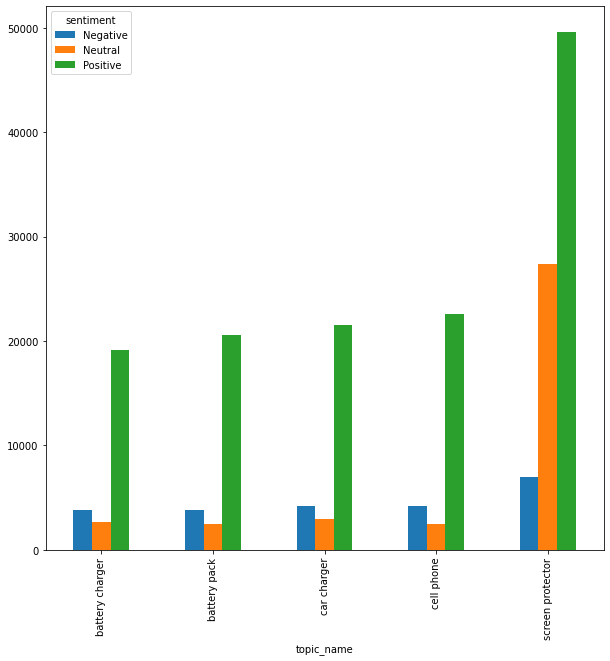

In [47]:
fig = graph_results.plot.bar(rot=90, figsize=(10,10))
fig.figure.savefig('sentiment_analysis.png', bbox_inches='tight')

In [48]:
from nltk.corpus import wordnet

def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        pass

positive_words = []
negative_words = []

for i in df['Dominant_topic'].unique():
    if i == 1:
        tmp_1 = df.loc[df['Dominant_topic'] == i]
                
        for j in tmp_1['tokenise'].values.tolist():
            for p in nltk.pos_tag(j):
                get_pos_tag = get_wordnet_pos(p[1])
                if type(get_pos_tag) == str:
                    try:        
                        synset = swn.senti_synset(p[0] + '.' + get_pos_tag +'.01')

                        if synset.obj_score() <= 0.49:
                            if synset.pos_score() > synset.neg_score() and p[0] in wn_affect:
                                    positive_words.append(p[0])
                            elif synset.neg_score() > synset.pos_score() and p[0] in wn_affect:
                                    negative_words.append(p[0])      
                    except:
                        pass

In [49]:
unique_positive_words = list(set(positive_words))
unique_negative_words = list(set(negative_words))

count_positive_words = []
count_negative_words = []

for i in unique_positive_words:
    counter = [i, positive_words.count(i)]
    count_positive_words.append(counter)

for i in unique_negative_words:
    counter = [i, negative_words.count(i)]
    count_negative_words.append(counter)    
    
positive_words = pd.DataFrame(count_positive_words, columns = ['word', 'score'])
negative_words = pd.DataFrame(count_negative_words, columns = ['word', 'score'])

positive_words.sort_values('score', ascending=False, inplace = True)
negative_words.sort_values('score', ascending=False, inplace = True)

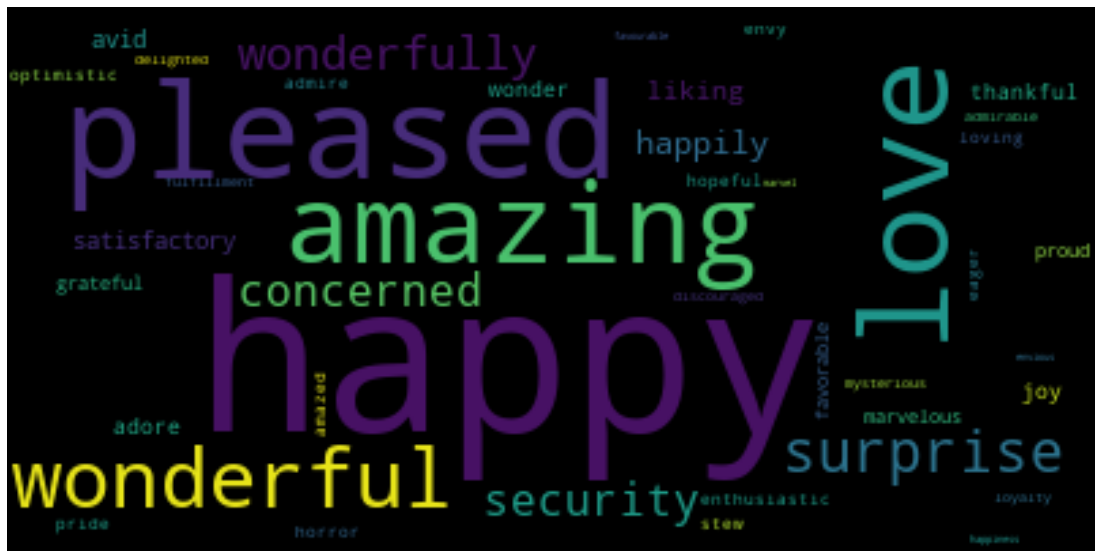

In [50]:
word_dict = {}
for k, v in positive_words.values:
    word_dict[k] = v

wordcloud = WordCloud()
wordcloud.generate_from_frequencies(frequencies=word_dict)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig('positive_words.png')
plt.show()

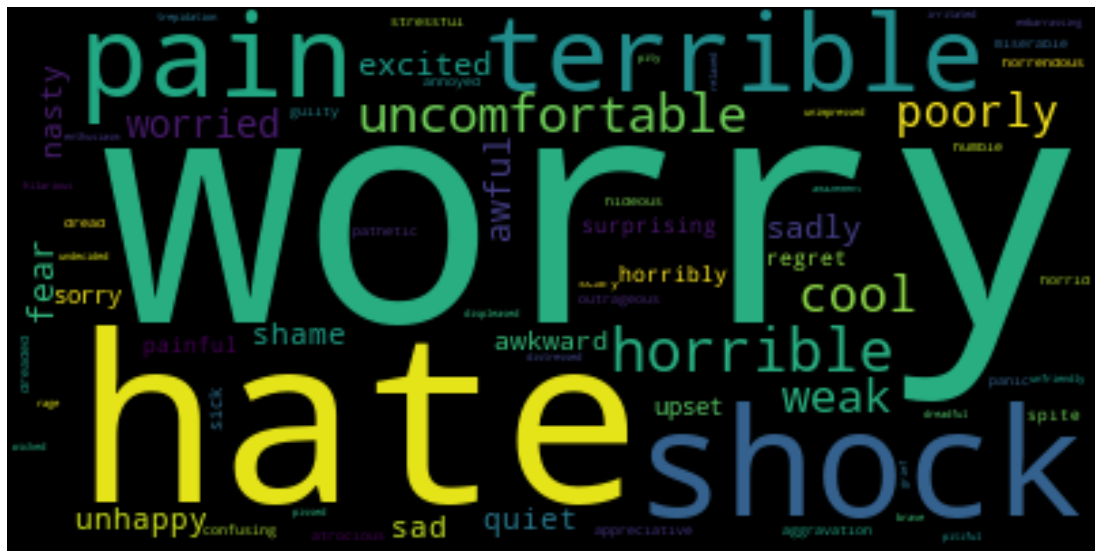

In [51]:
word_dict = {}
for k, v in negative_words.values:
    word_dict[k] = v
    
wordcloud.generate_from_frequencies(frequencies=word_dict)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig('negative_words.png')
plt.show()